In [33]:
import torch
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from datasets import load_dataset
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.transforms.functional import InterpolationMode
from utils import DiffusionModelPipeline, ImagePromptDataset

In [34]:
dit_params = {
    'channels': 384,
    'nBlocks': 8,
    'inC': 16, 
    'nHeads': 8,
    'patchSize': 2
}

cat_params = {
    'input_dim': 768,  # T5-base hidden size
    'hidden_dim': 512,
    'output_dim': 256,
    'num_layers': 3,
    'num_heads': 8
}
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
untrained_model = model = DiffusionModelPipeline(dit_params = dit_params,
                       cat_params = cat_params,
                       emaStrength= 0.999,
                       )

trained_1k_model = DiffusionModelPipeline.from_pretrained('pokemon_training_test/epoch_1000')

trained_best_model = DiffusionModelPipeline.from_pretrained('pokemon_training_test/best_model')

## Test Gen

In [35]:
prompts = ['A green pokemon with a leaf on its head',
                      'a red pokemon with a fire on its tail',
                      'a yellow cartoon character with a big smile',
                      'a cartoon frog character with a crown',]

steps = 10
shape = (len(prompts), untrained_model.latent_channels, 16, 16)
xT = torch.rand(shape).to(device)

Diffusion: 100%|██████████| 10/10 [00:00<00:00, 39.27it/s]


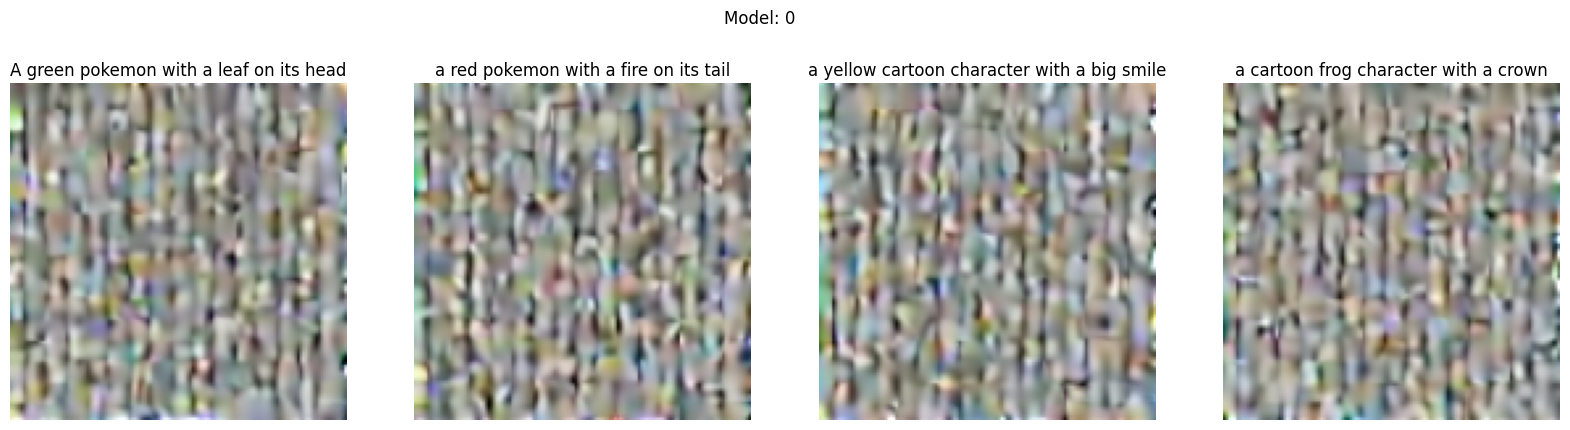

Diffusion: 100%|██████████| 10/10 [00:00<00:00, 95.23it/s]


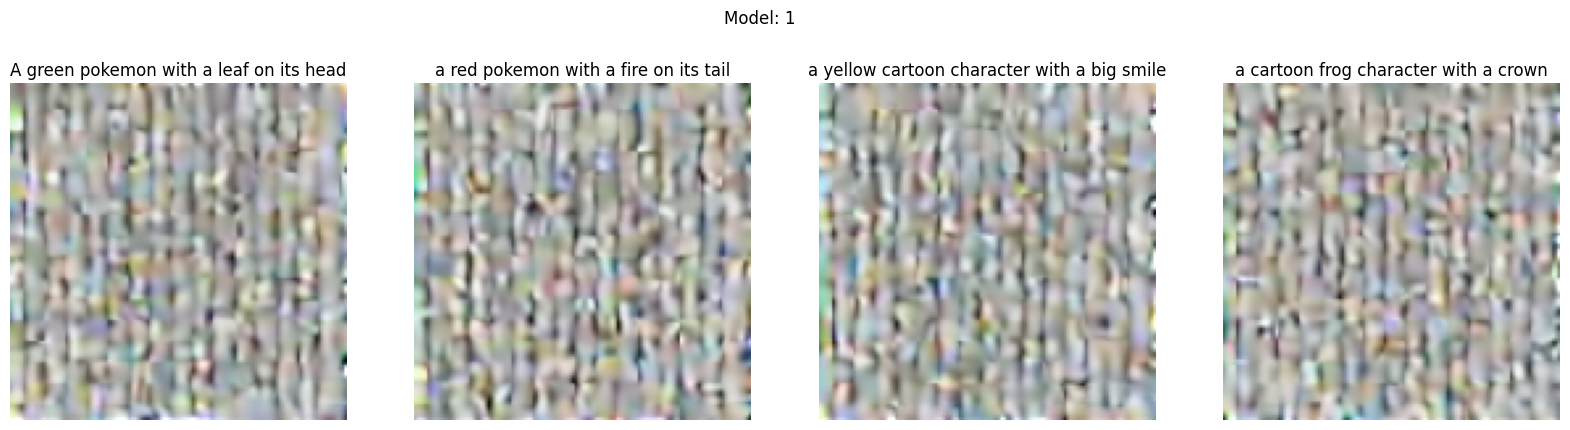

Diffusion: 100%|██████████| 10/10 [00:00<00:00, 97.13it/s]


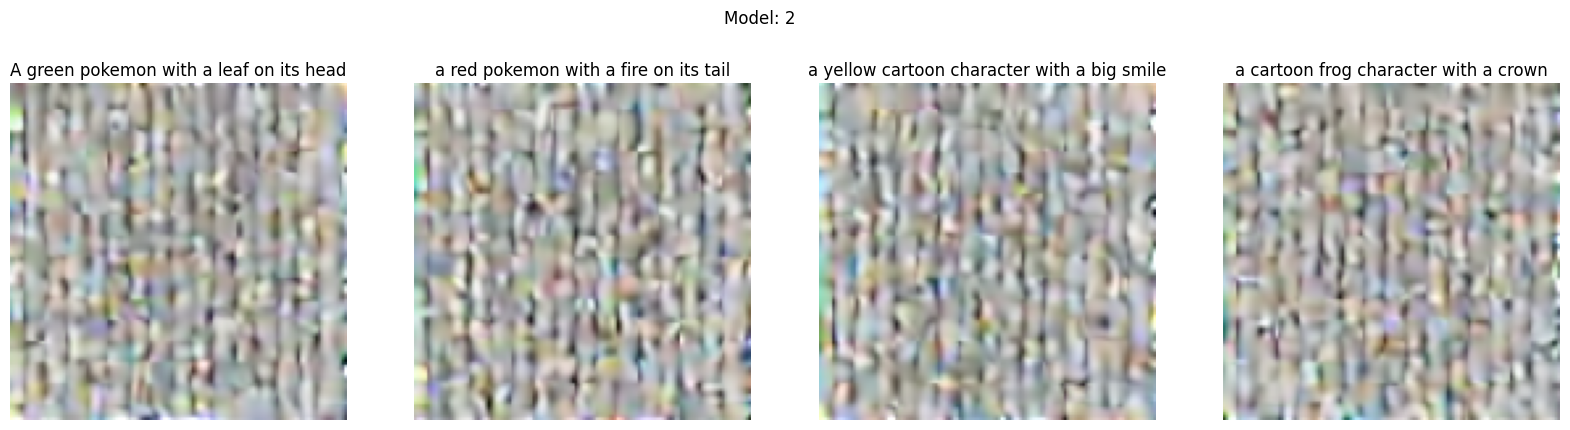

In [43]:

for ii, mod in enumerate([untrained_model, trained_1k_model, trained_best_model]):
    mod.to(device)
    mod.vae.eval()
    mod.text_encoder.eval()
    mod.cat.eval()
    mod.diffusion_model.model.eval()
    
    with torch.no_grad():
        
        text_embeddings = mod.encode_text(prompts)    
        
        ##Next we call the diffusion model -> hgere we do have XT random
        for i in tqdm(range(0, steps), desc="Diffusion"):
            latents = mod.diffusion_model.vSample(i, shape, xT, steps, text_embeddings)
        images = mod.decode_latents(latents)
        
    images = (images / 2 + 0.5).clamp(0, 1)
    images = images.cpu().permute(0, 2, 3, 1).numpy()
    
    fig, ax = plt.subplots(1, len(prompts), figsize=(20, 5))
    fig.suptitle(f"Model: {ii}")
    for i, img in enumerate(images):
        ax[i].imshow(img)
        ax[i].axis('off')
        ax[i].set_title(prompts[i])
    plt.show()
    

100%|██████████| 10/10 [00:00<00:00, 111.54it/s]


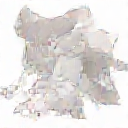

In [54]:
img = trained_best_model.generate(prompt='A green pokemon with a leaf on its head', num_inference_steps=10)
img[0]

100%|██████████| 50/50 [00:00<00:00, 100.52it/s]


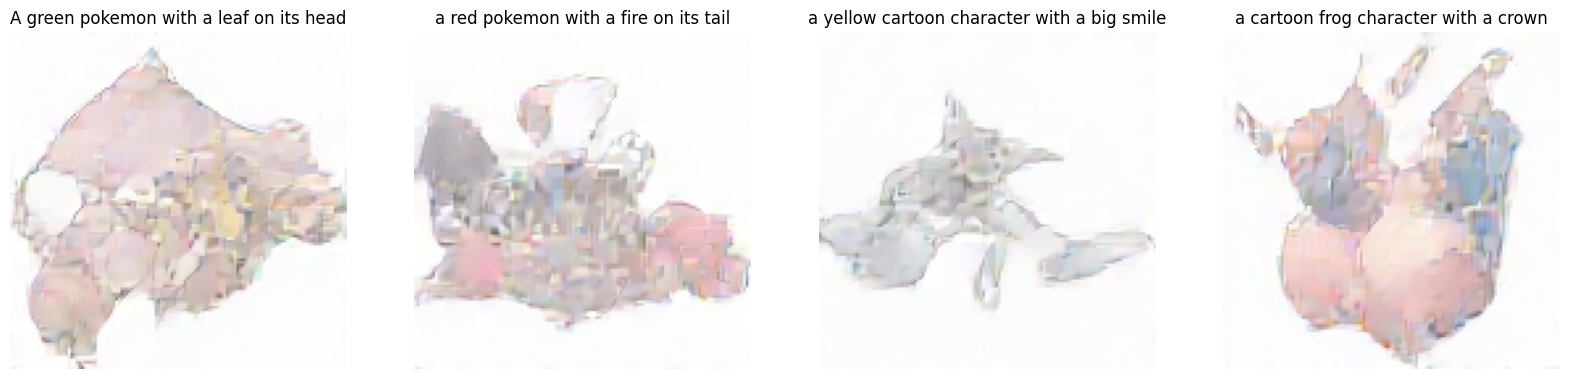

In [62]:
img = trained_best_model.generate(['A green pokemon with a leaf on its head',
                      'a red pokemon with a fire on its tail',
                      'a yellow cartoon character with a big smile',
                      'a cartoon frog character with a crown',],
               num_inference_steps=50)

fig, ax = plt.subplots(1, len(prompts), figsize=(20, 5))
for i, imgs in enumerate(img):
       ax[i].imshow(imgs)
       ax[i].axis('off')
       ax[i].set_title(prompts[i])
plt.show()

In [31]:
import numpy as np

np_img = np.array(img[0])
print(np_img.shape)

(512, 512, 3)


: 

In [22]:
dit_params = {
    'channels': 384,
    'nBlocks': 8,
    'inC': 16, 
    'nHeads': 8,
    'patchSize': 2
}

cat_params = {
    'input_dim': 768,  # T5-base hidden size
    'hidden_dim': 512,
    'output_dim': 256,
    'num_layers': 3,
    'num_heads': 8
}
untrained_model = DiffusionModelPipeline(dit_params = dit_params,
                       cat_params = cat_params,
                       emaStrength= 0.999,
                       device=device)

In [23]:
untrained_img = untrained_model.generate(['A green pokemon with a leaf on its head',
                      'a red pokemon with a fire on its tail',
                      'a yellow cartoon character with a big smile',
                      'a cartoon frog character with a crown',],
               num_inference_steps=50)

100%|██████████| 50/50 [00:03<00:00, 16.61it/s]


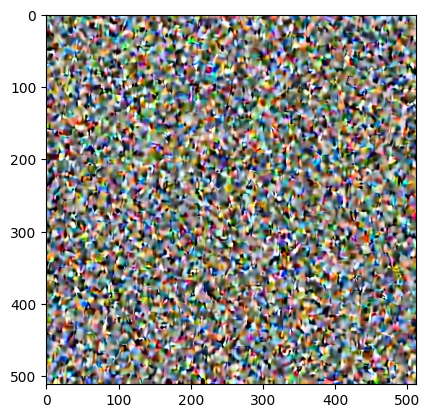

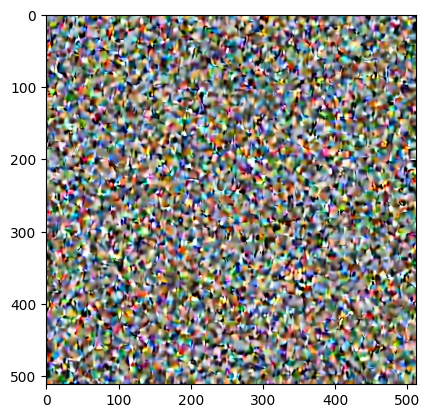

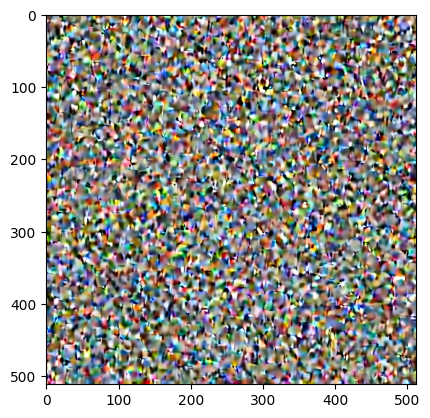

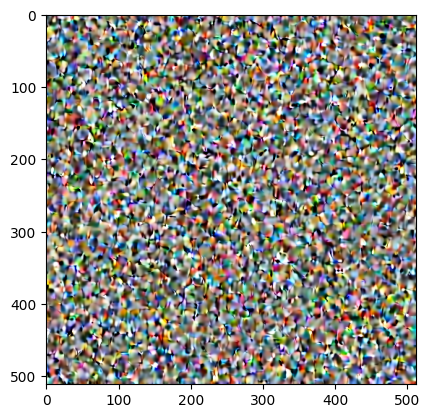

In [24]:
for i in range(len(untrained_img)):
    plt.imshow(untrained_img[i])
    plt.show()